 *Gareth Griffith 29/03/2020*
 
 ### Jupyter Notebook producing LSOA sample statistics and LSOA graphics for COVID 19 Symptom Tracker Data. 

#### Pipeline Output
This notebook outputs a 'lsoastats.csv' file containing population and sample estimates for LSOA summary statistics. The file contains a series of LSOA aggregated variables for the sample including mean age, sex ratio and counts of a series of health conditions contained in the data. Population reference values are taken from ONS and NRScotland population estimates for England, Scotland and Wales. Geospatial data is called directly by the script, and taken from Open GIS and NRS. This script incorporates UK Index of Multiple deprivation indices taken from Abel et al. (2016). Sources for files are indicated in annotation where files are not called directly. Dependencies and code to generate them are located in the shared OneDrive.

The column naming convention for 'lsoastats.csv' is as follows: prefix 'p_' implies population estimate, 's_' implies sample estimate. 

#### Data Inspection
Graphics are produced in the script (but not saved out) illustrating ascertainment and it's association with IMD. Sample mean age and sex ratio is also compared with population references. 

It is clear that sampling varies considerably by LSOA. AScertainment also varies considerably. There is some evidence that this is predicted by LSOA level socioeconomic position (as indicated by IMD estimates).

#### Mapping 
In order to further represent geographical patterning the notebook also outputs a series of graphics illustrating sampling characteristics by geography. Filenames indicate the LSOA characteristic mapped. Characteristics are listed below.

Maps of reporting in Great Britain (excluding Channel Islands and Isle of Man which are treated as single LSOAs and thus have very high sample N) are produced for for Sample N, Sample N deciles and Ascertainment. Maps of England and Wales are also produced for LSOA Sample Mean Age and LSOA Sample Mean Age Anomaly from ONS population estimates. Ascertainment is clearly geographically patterned, the south and urban areas are over represented, and England is broadly more represented than Scotland. Neither age nor age anomaly seem to illustrate analogous geographical patterning to ascertainment.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

%matplotlib inline

In [2]:
#Check encoding difference in geog-data file from KCL
df=pd.read_csv('patients_export_20200326_Only_geog.csv.gz', encoding = "latin-1" , low_memory=False)
df1=pd.read_csv('patients_export_20200326_Anonym_qc.csv.gz')

In [3]:
# Filter unreliable cases
df1=df1[df1.unreliable==False]

In [4]:
#LSOAref data taken from TTM generated Stata code
#Scottish values taken from here: https://www.nrscotland.gov.uk/files//statistics/population-estimates/sape-time-series/persons/sape-2018-persons.csv
lsoaref=pd.read_csv('lsoa_ages.csv')
lsoaref.head()

,lsoa,name,male_count,male_mean_age,female_count,female_mean_age
0,E01000001,City of London 001A,758,45.422165,678,46.989674
1,E01000002,City of London 001B,739,47.638702,679,43.058910
2,E01000003,City of London 001C,836,45.659092,744,45.436829
3,E01000005,City of London 001E,933,31.470526,768,33.877605
4,E01000006,Barking and Dagenham 016A,1030,33.620388,974,33.036961


In [5]:
Scotland=pd.read_csv('https://www.nrscotland.gov.uk/files//statistics/population-estimates/sape-time-series/persons/sape-2018-persons.csv',
                     skiprows=5,skipfooter = 2, engine='python')
scotmale=pd.read_csv('https://www.nrscotland.gov.uk/files//statistics/population-estimates/sape-time-series/males/sape-2018-males.csv',
                    skiprows=5,skipfooter = 2, engine='python')
Scotland=Scotland.iloc[:,:4]
Scotland=Scotland.rename(columns={'Unnamed: 3':'p_totpop',
                                 'DataZone2011Code':'lsoa',
                                 'DataZone2011Name':'name'})
Scotland['male_count']=scotmale['Unnamed: 3']
Scotland['male_count']=Scotland["male_count"].str.replace(",","").astype(float)
Scotland['p_totpop']=Scotland["p_totpop"].str.replace(",","").astype(float)
Scotland['female_count']=(Scotland['p_totpop'] - Scotland['male_count'])

lsoaref=lsoaref.append(Scotland, ignore_index=True)
lsoaref=lsoaref.iloc[:,:6]
lsoaref.tail()

,lsoa,name,male_count,male_mean_age,female_count,female_mean_age
41724,S01013477,Broxburn South - 06,322.0,NaN,288.0,NaN
41725,S01013478,Broxburn East - 01,445.0,NaN,391.0,NaN
41726,S01013479,Broxburn East - 02,376.0,NaN,416.0,NaN
41727,S01013480,Broxburn East - 03,355.0,NaN,348.0,NaN
41728,S01013481,Broxburn East - 04,272.0,NaN,286.0,NaN


 IMD Data taken from Bristol (Abel et al. 2016) cross-country comparison:\\https://data.bris.ac.uk/data/dataset/1ef3q32gybk001v77c1ifmty7x
 
 Scotland data doesn't match up - IMD scores in scotland are at generated for different geographical scale

In [6]:
imd=pd.read_csv('UK_IMD_scores.csv')
imd.head()

,ctry,area_code,income,employ,original_imd_score,original_imd_quintile,uk_imd_england_score,uk_imd_england_quintile,uk_imd_ni_score,uk_imd_ni_quintile,uk_imd_scotland_score,uk_imd_scotland_quintile,uk_imd_wales_score,uk_imd_wales_quintile
0,England,E01000001,1.1,1.5,6.1,1 - least deprived,6.1,1 - least deprived,-1.2,1 - least deprived,4.4,1 - least deprived,1.8,1 - least deprived
1,England,E01000002,1.2,1.7,6.3,1 - least deprived,6.3,1 - least deprived,-1.0,1 - least deprived,4.6,1 - least deprived,2.0,1 - least deprived
2,England,E01000003,10.5,8.8,19.5,3,19.5,3,10.7,3,18.3,3,15.5,3
3,England,E01000005,21.7,14.4,26.0,4,26.0,4,16.5,4,25.9,4,22.5,4
4,England,E01000006,13.3,9.4,22.6,4,22.6,4,13.0,3,21.1,3,18.7,4


In [7]:
master=df.merge(df1, how='outer', on='id')

#quick sanity check on bmi vals
master[master.bmi>=1000].count().max()

0

In [8]:
## Recode strings 't', 'f' to Boolean vals.
binlist= ['has_diabetes', 'has_heart_disease', 'has_lung_disease',
          'height_feet', 'is_smoker','does_chemiotherapy', 
          'has_kidney_disease', 'housebound_problems', 
          'mobility_aid', 'limited_activity', 'takes_corticosteroids',
          'takes_immunosuppressants', 'help_available','needs_help',
          'already_had_covid', 'classic_symptoms',
          'takes_blood_pressure_medications', 'need_inside_help',
          'need_outside_help', 'contact_health_worker', 'is_in_uk_twins',
          'unreliable', 'unreliable_reason']
for attribute in binlist:
    master[attribute] = (master[attribute]=='t')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:252: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [9]:
# 10 highest reporting LSOAs
counts = master.groupby('lsoa11cd').lsoa11cd.count()
sorted(counts)[-10:]
#counts1 = master.groupby('ladcd').ladcd.count()

[188, 201, 203, 206, 209, 220, 223, 246, 449, 982]

In [10]:
lsoa = pd.DataFrame(master.groupby('lsoa11cd').lsoa11cd.count())
lsoa = lsoa.rename(columns={'lsoa11cd':'nsamp'})
lsoa = lsoa.reset_index()
lsoa = lsoa.merge(imd[['area_code','income', 'employ', 'uk_imd_england_score']], how='left', left_on='lsoa11cd', right_on='area_code')
lsoa = lsoa.merge(lsoaref, how='left', left_on= 'lsoa11cd', right_on='lsoa')
lsoa['npop'] = (lsoa.male_count + lsoa.female_count)
lsoa['popage'] = ((lsoa.male_count*lsoa.male_mean_age)+(lsoa.female_count*lsoa.female_mean_age))/lsoa.npop
lsoa['popfem'] = (lsoa.female_count/lsoa.npop)
    
#lsoa.head() gives NI LSOAs at top which are missing from reference pop ests.
lsoa.tail()

,lsoa11cd,nsamp,area_code,income,employ,uk_imd_england_score,lsoa,name,male_count,male_mean_age,female_count,female_mean_age,npop,popage,popfem
39762,W01001954,35,W01001954,5.0,5.0,6.0,W01001954,Cardiff 006F,697.0,46.249641,767.0,47.813560,1464.0,47.068989,0.523907
39763,W01001955,10,W01001955,40.0,38.0,70.9,W01001955,Swansea 025F,1163.0,40.862423,683.0,44.130306,1846.0,42.071504,0.369989
39764,W01001956,40,W01001956,5.0,3.0,6.5,W01001956,Swansea 023E,1195.0,36.607533,1174.0,40.076660,2369.0,38.326720,0.495568
39765,W01001957,6,W01001957,17.0,12.0,25.7,W01001957,Swansea 025G,638.0,35.891850,389.0,43.419022,1027.0,38.742940,0.378773
39766,W01001958,27,W01001958,11.0,9.0,18.0,W01001958,Swansea 025H,960.0,35.583332,572.0,39.795456,1532.0,37.156005,0.373368


In [11]:
samp = pd.DataFrame(master.groupby('lsoa11cd').year_of_birth.mean())
samp = samp.reset_index()
samp = samp.merge(master.groupby('lsoa11cd').gender.mean(), on='lsoa11cd')
samp = samp.merge(master.groupby('lsoa11cd').bmi.mean(), on='lsoa11cd')
samp = samp.merge(master.groupby('lsoa11cd').is_smoker.sum(), on='lsoa11cd')
samp = samp.merge(master.groupby('lsoa11cd').has_diabetes.sum(), on='lsoa11cd')
samp = samp.merge(master.groupby('lsoa11cd').has_heart_disease.sum(), on='lsoa11cd')
samp = samp.merge(master.groupby('lsoa11cd').has_lung_disease.sum(), on='lsoa11cd')
samp = samp.merge(master.groupby('lsoa11cd').housebound_problems.sum(), on='lsoa11cd')
samp = samp.merge(master.groupby('lsoa11cd').already_had_covid.sum(), on='lsoa11cd')
samp = samp.merge(master.groupby('lsoa11cd').classic_symptoms.sum(), on='lsoa11cd')
samp['year_of_birth'] = 2020 - samp['year_of_birth']

samp.head()

,lsoa11cd,year_of_birth,gender,bmi,is_smoker,has_diabetes,has_heart_disease,has_lung_disease,housebound_problems,already_had_covid,classic_symptoms
0,95AA01S1,35.800000,0.550000,29.071933,3.0,0.0,0.0,2.0,0.0,0.0,0.0
1,95AA01S2,41.388889,0.500000,27.423257,2.0,0.0,1.0,2.0,0.0,0.0,0.0
2,95AA01S3,39.454545,0.454545,25.189998,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,95AA02W1,40.333333,0.444444,27.436832,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,95AA03W1,33.400000,0.600000,29.249246,2.0,0.0,0.0,5.0,0.0,0.0,1.0


In [12]:
lsoafull = samp.merge(lsoa, how= 'outer', on='lsoa11cd')
lsoafull.tail()

,lsoa11cd,year_of_birth,gender,bmi,is_smoker,has_diabetes,has_heart_disease,has_lung_disease,housebound_problems,already_had_covid,...,uk_imd_england_score,lsoa,name,male_count,male_mean_age,female_count,female_mean_age,npop,popage,popfem
39762,W01001954,45.382353,0.352941,26.181397,2.0,0.0,0.0,5.0,0.0,1.0,...,6.0,W01001954,Cardiff 006F,697.0,46.249641,767.0,47.813560,1464.0,47.068989,0.523907
39763,W01001955,34.888889,0.333333,26.573536,3.0,0.0,0.0,2.0,0.0,0.0,...,70.9,W01001955,Swansea 025F,1163.0,40.862423,683.0,44.130306,1846.0,42.071504,0.369989
39764,W01001956,40.052632,0.315789,27.405530,2.0,0.0,1.0,5.0,0.0,0.0,...,6.5,W01001956,Swansea 023E,1195.0,36.607533,1174.0,40.076660,2369.0,38.326720,0.495568
39765,W01001957,46.000000,0.000000,30.325058,0.0,1.0,1.0,0.0,0.0,0.0,...,25.7,W01001957,Swansea 025G,638.0,35.891850,389.0,43.419022,1027.0,38.742940,0.378773
39766,W01001958,45.307692,0.500000,26.043777,0.0,2.0,1.0,2.0,0.0,0.0,...,18.0,W01001958,Swansea 025H,960.0,35.583332,572.0,39.795456,1532.0,37.156005,0.373368


In [13]:
lsoafull=lsoafull.rename(columns={ 'year_of_birth':'s_meanage', 'gender':'s_gend', 'bmi':'sbmi',
                                  'is_smoker':'s_smoke','has_diabetes':'s_diab', 'has_heart_disease':'s_heartdis',
                                  'has_lung_disease':'s_lungdis','housebound_problems':'s_hsprob',
                                  'already_had_covid':'s_already', 'classic_symptoms':'s_symp', 'nsamp':'s_nsamp',
                                  'income':'p_imd_inc', 'employ':'p_imd_emp', 'uk_imd_england_score':'p_imd', 
                                  'male_count':'p_malen', 'male_mean_age':'p_maleage', 'female_count':'p_femn',
                                  'female_mean_age':'p_femage','npop':'p_totpop', 'popage':'p_meanage', 'popfem':'p_gend'})

lsoafull['s_rawasc']= lsoafull.s_nsamp/lsoafull.p_totpop
lsoafull['s_asc'] = (lsoafull.s_nsamp/lsoafull.s_nsamp.sum())/(lsoafull.p_totpop/lsoafull.p_totpop.sum())

# Generating Mapping variables
lsoafull['s_nsamp_decile']=pd.qcut(lsoafull['s_nsamp'],10,labels=False)
lsoafull['anom_meanage']=lsoafull.p_meanage - lsoafull.s_meanage
lsoafull['anom_meanage_mask']=lsoafull.anom_meanage.mask(lsoafull['anom_meanage'].between(-50,-20))
lsoafull['s_nsamp_noislands']=lsoafull.s_nsamp.mask(lsoafull['s_nsamp'].between(250,1000))
lsoafull.to_csv('lsoastats.csv')

## Data Inspection

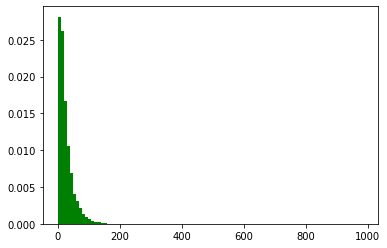

In [14]:
lsoacount=plt.hist(counts, 100, density=True, facecolor='g')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


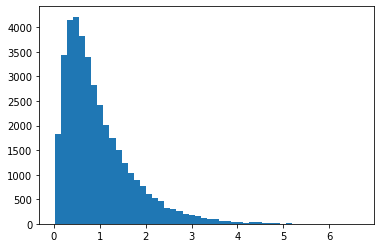

In [15]:
asc=plt.hist(lsoafull.s_asc, bins=50)

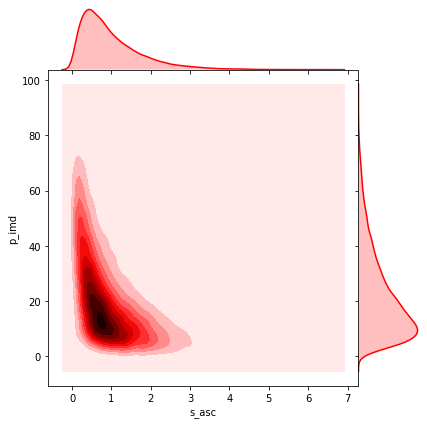

In [16]:
asc = sns.jointplot(x="s_asc", y="p_imd", data=lsoafull,
                 kind="kde", space=0, color="r")

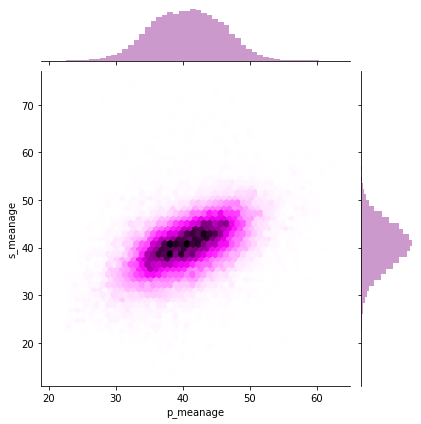

In [17]:
age = sns.jointplot(x="p_meanage", y="s_meanage", data=lsoafull,
                  color="purple", kind='hex')

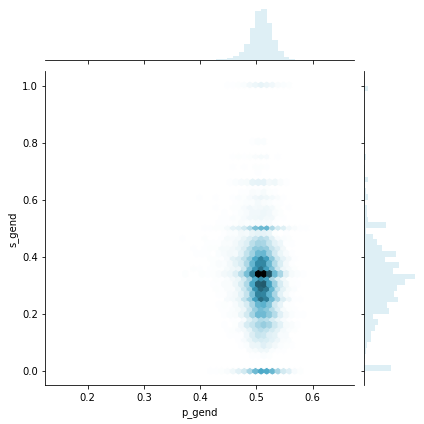

In [18]:
sex = sns.jointplot(x='p_gend', y='s_gend', data=lsoafull, 
                  color='lightblue', kind = 'hex')

## Mapping LSOA Sample characteristics

In [19]:
engwales = gpd.read_file('https://opendata.arcgis.com/datasets/007577eeb8e34c62a1844df090a93128_0.zip?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D')
scot= gpd.read_file('http://sedsh127.sedsh.gov.uk/Atom_data/ScotGov/ZippedShapefiles/SG_DataZoneBdry_2011.zip')
engwales=engwales.to_crs("EPSG:4326")
scot=scot.to_crs("EPSG:4326")

In [20]:
master = engwales.merge(lsoafull, how='outer', left_on='LSOA11CD', right_on='lsoa11cd')
master['s_asc_z']=master.s_asc.replace(np.nan, 0)
masterscot = scot.merge(lsoafull, how='outer', left_on='DataZone', right_on='lsoa11cd')
masterscot['s_asc_z']=masterscot.s_asc.replace(np.nan, 0)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


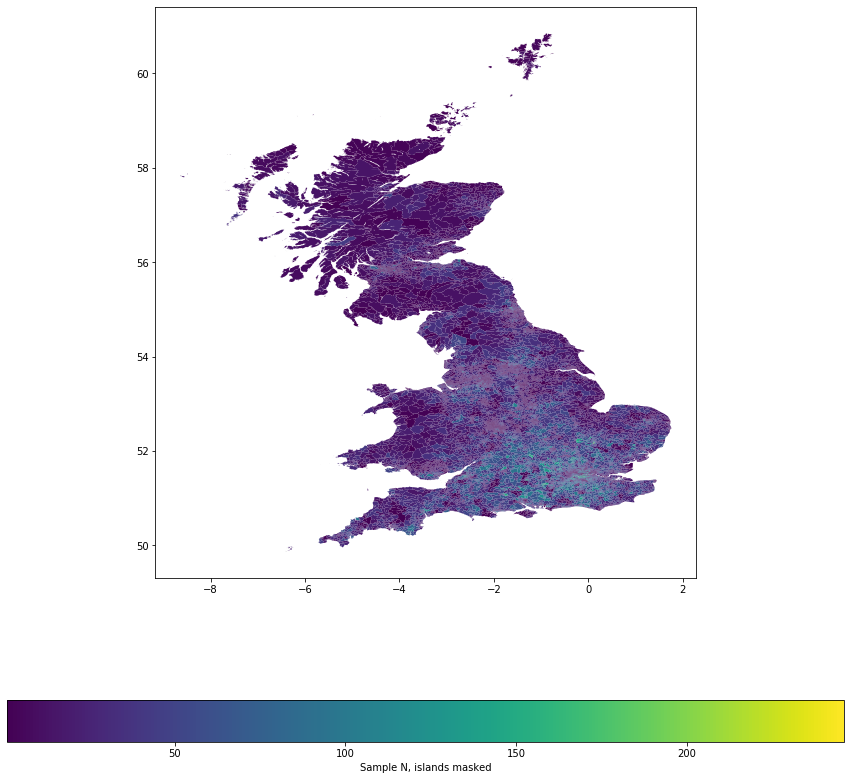

In [21]:
f, ax = plt.subplots(1,figsize=(15, 15))

master.append(masterscot).plot(column='s_nsamp_noislands',
                              ax=ax, legend=True, 
                              legend_kwds = {'label':'Sample N, islands masked',
                                            'orientation': 'horizontal'})
plt.savefig('ESW_SampN.png', dpi=200)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


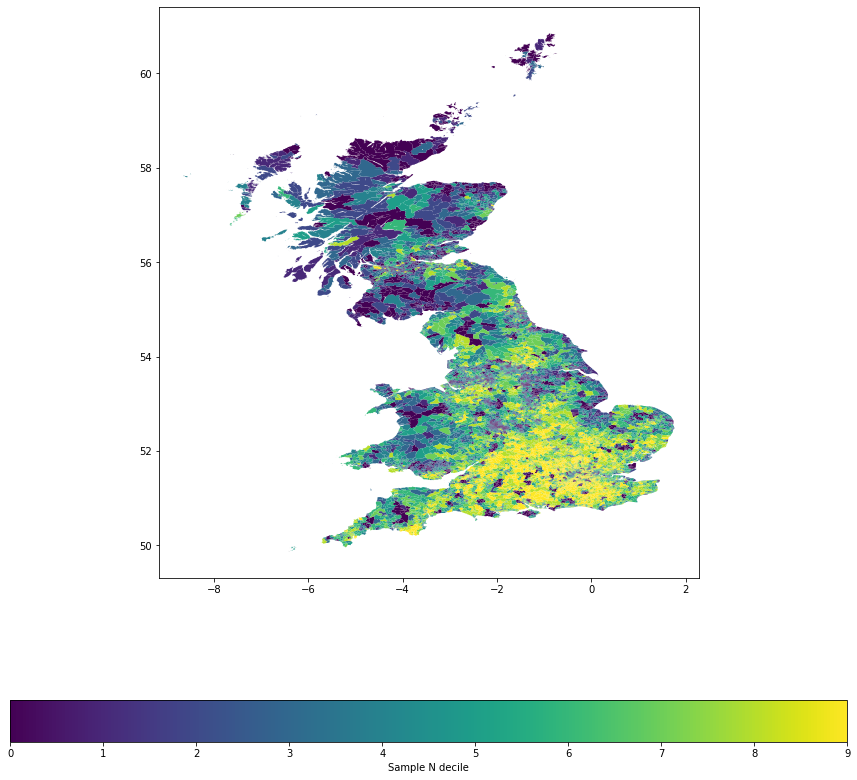

In [22]:
f, ax = plt.subplots(1,figsize=(15, 15))

master.append(masterscot).plot(column='s_nsamp_decile',
                              ax=ax, legend=True, 
                              legend_kwds = {'label':'Sample N decile',
                                            'orientation': 'horizontal'})
plt.savefig('ESW_SampN_Decile.png', dpi=200)

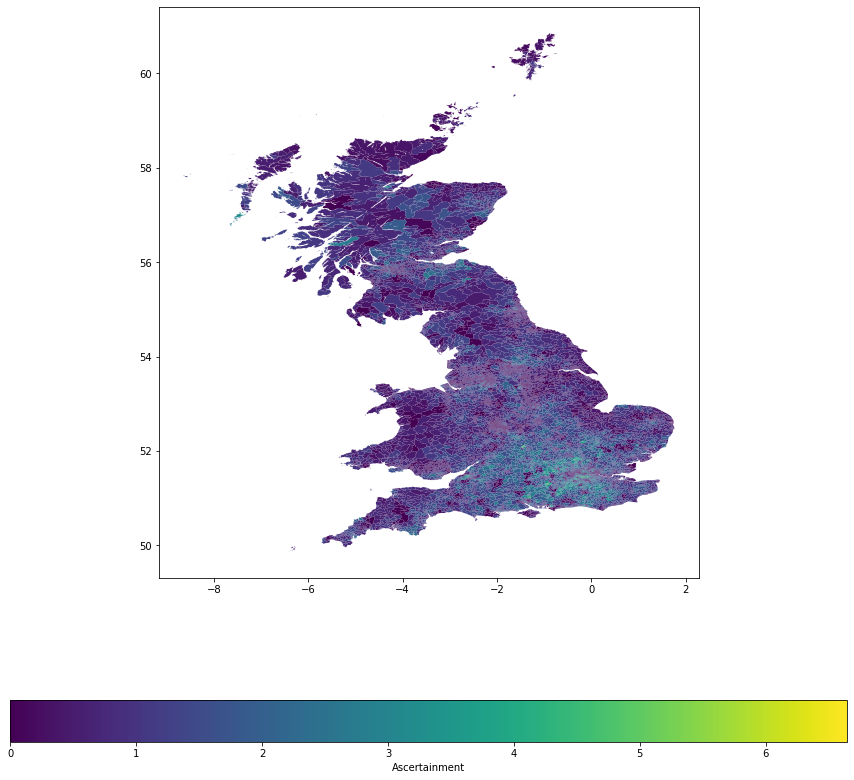

In [23]:
f, ax = plt.subplots(1,figsize=(15, 15))

master.append(masterscot).plot(column='s_asc_z',
                              ax=ax, legend=True, 
                              legend_kwds = {'label':'Ascertainment',
                                            'orientation': 'horizontal'})
plt.savefig('ESWasc.png', dpi=200)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


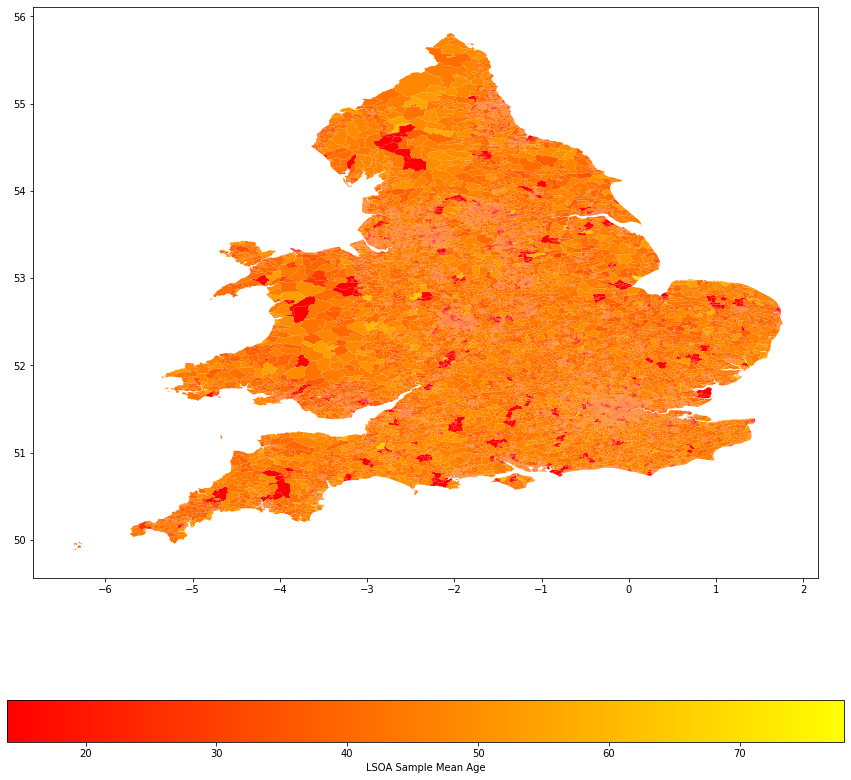

In [24]:
f, ax = plt.subplots(1,figsize=(15, 15))

master.plot(column=('s_meanage'),
            ax=ax, legend=True,
            legend_kwds = {'label':'LSOA Sample Mean Age',
                           'orientation': 'horizontal'},
           cmap='autumn')
plt.savefig('EW_MeanAge.png', dpi=200)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


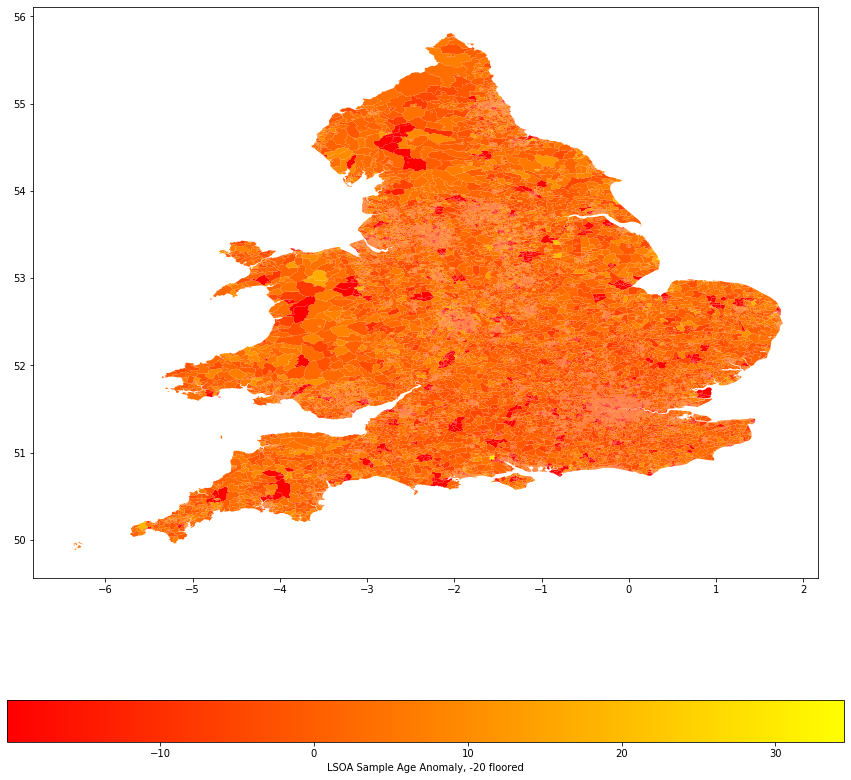

In [26]:
f, ax = plt.subplots(1,figsize=(15, 15))

master.plot(column=('anom_meanage_mask'),
            ax=ax, legend=True,
            legend_kwds = {'label':'LSOA Sample Age Anomaly, -20 floored',
                           'orientation': 'horizontal'},
           cmap='autumn')
plt.savefig('EW_MeanAge.png', dpi=200)